In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
import cv2



original_image = cv2.imread('Images/01.png')
image = color.rgb2gray(original_image)

print("original: %s --> grayscale: %s" % (original_image.shape, image.shape))
# cv2.imshow("original image",original_image)



original: (216, 216, 3) --> grayscale: (216, 216)


In [3]:
def compute_gradient(image: np.ndarray):
    """
    Compute gradient of an image by rows and columns
    """
    gx = np.zeros_like(image)
    gy = np.zeros_like(image)
    # Central difference
    gx[:, 1:-1] = (image[:, 2:] - image[:, :-2]) / 2
    gy[1:-1, :] = (image[2:, :] - image[:-2, :]) / 2

    # Forward difference
    gx[:, 0] = image[:, 1] - image[:, 0]
    gy[0, :] = image[1, :] - image[0, :]

    # Backward difference
    gx[:, -1] = image[:, -1] - image[:, -2]
    gy[-1, :] = image[-1, :] - image[-2, :]

    return gx, gy

gx, gy = compute_gradient(image)

# Check with np.gradient()
gy_check, gx_check = np.gradient(image) # Note that the result of np.gradient is in the reversed order

print('diff_gx:', np.linalg.norm(gx - gx_check))
print('diff_gy', np.linalg.norm(gy - gy_check))

diff_gx: 0.0
diff_gy 0.0


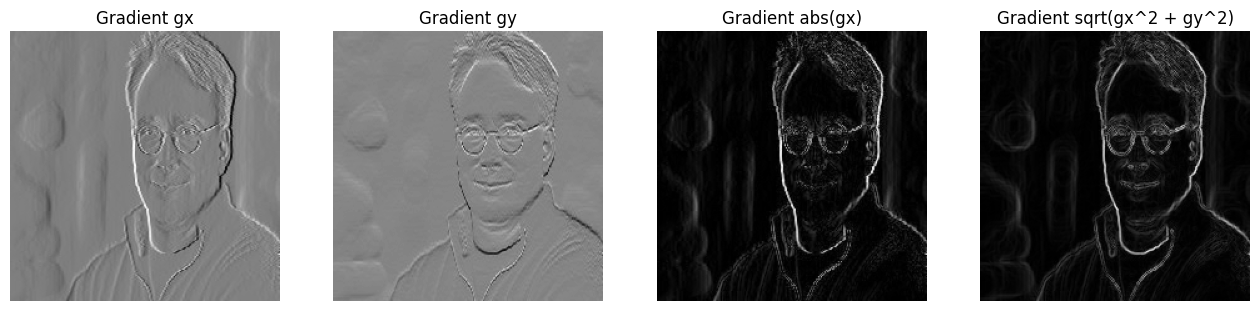

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off') 

ax1.imshow(gx, cmap=plt.get_cmap('gray'))
ax1.set_title('Gradient gx')

ax2.imshow(gy, cmap=plt.get_cmap('gray'))
ax2.set_title('Gradient gy')

ax3.imshow(np.abs(gx), cmap=plt.get_cmap('gray'))
ax3.set_title('Gradient abs(gx)')

ax4.imshow(np.hypot(gx, gy), cmap=plt.get_cmap('gray')) # np.hypo(gx, gy) = np.sqrt(gx**2 + gy**2)
ax4.set_title('Gradient sqrt(gx^2 + gy^2)')
plt.show()


In [35]:
def compute_hog_cell(n_orientations: int, magnitudes: np.ndarray, orientations: np.ndarray) -> np.ndarray:
    """
    Compute 1 HOG feature of a cell. Return a row vector of size `n_orientations`
    """
    bin_width = int(180 / n_orientations)
    hog = np.zeros(n_orientations)
    for i in range(orientations.shape[0]):
        for j in range(orientations.shape[1]):
            orientation = orientations[i, j]
            lower_bin_idx = int(orientation / bin_width)
            hog[lower_bin_idx] += magnitudes[i, j]

    return hog / (magnitudes.shape[0] * magnitudes.shape[1])


In [36]:
def normalize_vector(v, eps=1e-5):
    """
    Return a normalized vector (which has norm2 as 1) 
    """
    # eps is used to prevent zero divide exceptions (in case v is zero)
    return v / np.sqrt(np.sum(v ** 2) + eps ** 2) 


def compute_hog_features(image: np.ndarray,
                         n_orientations: int = 9, pixels_per_cell: (int, int) = (8, 8),
                         cells_per_block: (int, int) = (1, 1)) -> np.ndarray:
    """
    Compute HOG features of an image. Return a row vector
    """
    gx, gy = compute_gradient(image)
    sy, sx = gx.shape
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    magnitudes = np.hypot(gx, gy)   # = np.sqrt(gx**2 + gy**2)
    orientations = np.rad2deg(np.arctan2(gy, gx)) % 180

    n_cellsx = int(sx / cx) # Number of cells in x axis
    n_cellsy = int(sy / cy) # Number of cells in y axis
    n_blocksx = int(n_cellsx - bx) + 1
    n_blocksy = int(n_cellsy - by) + 1

    hog_cells = np.zeros((n_cellsx, n_cellsy, n_orientations))

    prev_x = 0
    # Compute HOG of each cell
    for it_x in range(n_cellsx):
        prev_y = 0
        for it_y in range(n_cellsy):
            magnitudes_patch = magnitudes[prev_y:prev_y + cy, prev_x:prev_x + cx]
            orientations_patch = orientations[prev_y:prev_y + cy, prev_x:prev_x + cx]

            hog_cells[it_y, it_x] = compute_hog_cell(n_orientations, magnitudes_patch, orientations_patch)

            prev_y += cy
        prev_x += cx

    hog_blocks_normalized = np.zeros((n_blocksx, n_blocksy, n_orientations))

    # Normalize HOG by block
    for it_blocksx in range(n_blocksx):
        for it_blocky in range(n_blocksy):
            hog_block = hog_cells[it_blocky:it_blocky + by, it_blocksx:it_blocksx + bx].ravel()
            hog_blocks_normalized[it_blocky, it_blocksx] = normalize_vector(hog_block)

    return hog_blocks_normalized.ravel()


In [37]:
# Compare the results with skimage.feature.hog
hog_features = compute_hog_features(
    image, n_orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(1, 1))

from skimage.feature import hog

hog_features_check = hog(
    image, orientations=9,
    pixels_per_cell=(8, 8), cells_per_block=(1, 1),
    block_norm='L2')

assert hog_features.shape == hog_features_check.shape
print(np.allclose(hog_features, hog_features_check))
print(hog_features.shape)


False
(6561,)


/tmp/ipykernel_59732/1138092455.py:6: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(original_image, orientations=9, pixels_per_cell=(8, 8),


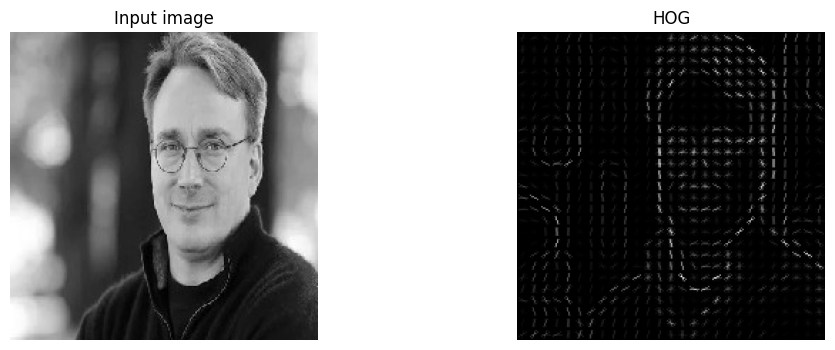

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

# _, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(1, 1), block_norm='L2',visualise=True)
fd, hog_image = hog(original_image, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.axis('off'); ax2.axis('off')
ax1.imshow(image, cmap=plt.get_cmap('gray'))
ax1.set_title('Input image')

ax2.imshow(hog_image, cmap=plt.get_cmap('gray'))
ax2.set_title('HOG')
plt.show()